In [34]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime
import math

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from scipy.sparse import csr_matrix, hstack

In [4]:
df_train = pd.read_csv(filepath_or_buffer="data/train.tsv", sep="\t", )
df_test = pd.read_csv(filepath_or_buffer="data/test.tsv", sep="\t", )

In [5]:
print("Dataset dimensions - Train: ", df_train.shape)
print("Dataset dimensions - Test: ", df_test.shape)

Dataset dimensions - Train:  (1482535, 8)
Dataset dimensions - Test:  (693359, 7)


In [6]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [10]:
# df_input = pd.concat([df_train, df_test], 0)
# nrow_train = df_train.shape[0]
df_input = df_train

In [11]:
df_input['category_name'].fillna(value='other', inplace=True)
df_input['brand_name'].fillna(value='other', inplace=True)
df_input['item_description'].fillna(value='other', inplace=True)

df_test['category_name'].fillna(value='other', inplace=True)
df_test['brand_name'].fillna(value='other', inplace=True)
df_test['item_description'].fillna(value='other', inplace=True)

In [12]:
df_input['category_name'] = df_input['category_name'].astype('category')
df_input['brand_name'] = df_input['brand_name'].astype('category')
df_input['item_condition_id'] = df_input['item_condition_id'].astype('category')

df_test['category_name'] = df_test['category_name'].astype('category')
df_test['brand_name'] = df_test['brand_name'].astype('category')
df_test['item_condition_id'] = df_test['item_condition_id'].astype('category')

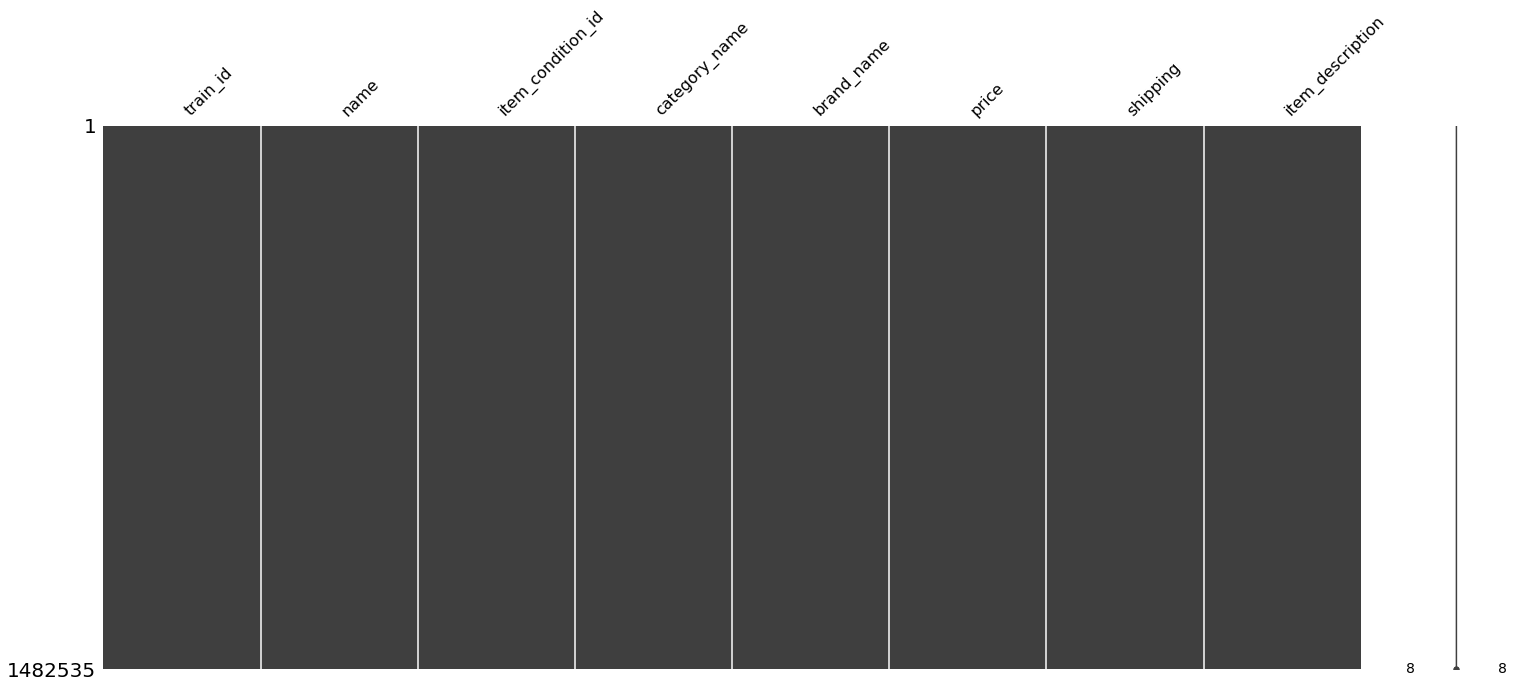

In [13]:
msno.matrix(df_input)

In [14]:
df_input.dtypes

train_id                int64
name                   object
item_condition_id    category
category_name        category
brand_name           category
price                 float64
shipping                int64
item_description       object
dtype: object

In [15]:
def func_count_vectorizer(df_in, var_col):
    model_cv = CountVectorizer(min_df=10)
    return model_cv.fit_transform(df_in[var_col])

In [16]:
mat_input_name_cv = func_count_vectorizer(df_input, "name")
mat_input_category_name_cv = func_count_vectorizer(df_input, "category_name")
mat_input_brand_name_cv = func_count_vectorizer(df_input, "brand_name")
mat_input_item_desc_cv = func_count_vectorizer(df_input, "item_description")

In [17]:
print("--- Matrix Dimensions ---")
print("mat_input_name_cv", mat_input_name_cv.shape)
print("mat_input_category_name_cv", mat_input_category_name_cv.shape)
print("mat_input_brand_name_cv", mat_input_brand_name_cv.shape)
print("mat_input_item_desc_cv", mat_input_item_desc_cv.shape)

--- Matrix Dimensions ---
mat_input_name_cv (1482535, 17740)
mat_input_category_name_cv (1482535, 864)
mat_input_brand_name_cv (1482535, 2183)
mat_input_item_desc_cv (1482535, 32103)


In [18]:
def func_tfidf_vectorizer(df_in, var_col):
    model_tfidf = TfidfVectorizer(max_features = 55000, ngram_range = (1,3), stop_words = "english")
    return model_tfidf.fit_transform(df_in[var_col])

In [19]:
mat_input_name_tfidf = func_count_vectorizer(df_input, "name")
mat_input_category_name_tfidf = func_count_vectorizer(df_input, "category_name")
mat_input_brand_name_tfidf = func_count_vectorizer(df_input, "brand_name")
mat_input_item_desc_tfidf = func_count_vectorizer(df_input, "item_description")

In [20]:
print("--- Matrix Dimensions ---")
print("mat_input_name_tfidf", mat_input_name_tfidf.shape)
print("mat_input_category_name_tfidf", mat_input_category_name_tfidf.shape)
print("mat_input_brand_name_tfidf", mat_input_brand_name_tfidf.shape)
print("mat_input_item_desc_tfidf", mat_input_item_desc_tfidf.shape)

--- Matrix Dimensions ---
mat_input_name_tfidf (1482535, 17740)
mat_input_category_name_tfidf (1482535, 864)
mat_input_brand_name_tfidf (1482535, 2183)
mat_input_item_desc_tfidf (1482535, 32103)


In [27]:
mat_input_stack = sp.sparse.hstack((mat_input_name_cv, 
                                       mat_input_category_name_cv,
                                       mat_input_brand_name_cv,
                                       mat_input_item_desc_cv,
                                       mat_input_name_tfidf,
                                       mat_input_category_name_tfidf,
                                       mat_input_brand_name_tfidf,
                                       mat_input_item_desc_tfidf)).tocsr()

In [28]:
mat_input_stack.shape

(1482535, 105780)

In [29]:
# #Test-Train Split
X = mat_input_stack
y = np.log1p(df_input["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
print("Train Dataset Shape - X_train: ", X_train.shape)
print("Train Dataset Shape - y_train: ", y_train.shape)
print("--------------------------------")
print("Test Dataset Shape - X_test: ", X_test.shape)
print("Test Dataset Shape - y_test: ", y_test.shape)

Train Dataset Shape - X_train:  (1037774, 105780)
Train Dataset Shape - y_train:  (1037774,)
--------------------------------
Test Dataset Shape - X_test:  (444761, 105780)
Test Dataset Shape - y_test:  (444761,)


In [36]:
model_2 = Ridge(solver = "lsqr", fit_intercept=False)

In [37]:
# model_2 = RandomForestRegressor(max_depth=15, random_state=0, n_jobs=-1)
model_2.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [38]:
y_predict = model_2.predict(X_test)

In [39]:
math.sqrt(mean_squared_log_error(y_predict, y_test))

0.1341440687002028

In [ ]:
y_predict

In [ ]:
df_model_2_submission = pd.DataFrame()
df_model_2_submission['test_id'] = df_test['test_id']
df_model_2_submission['price'] = pd.Series(y_predict)
df_model_2_submission.to_csv("submissions/model_2_submission_1.csv", index=False)

In [ ]:
!head submissions/model_2_submission_1.csv